CODE OVERVIEW:

- Calculates the similarity with respect to shape and charges of the molecules targeting various proteins 
- ESP calculation uses getbest=False parameter - meaning each molecules are aligned via shape and aligned again via charges 
- Molecules are provided in the DUD folder 
- ROC scores are calculated to test the performance of the ML model 

INSTRUCTIONS BEFORE RUNNING CODE 
- Unzip files of all actives and decoys molecules in the DUD file 

In [122]:
from rdkit import Chem 
from rdkit.Chem import Draw 
from ipywidgets import interact, interactive, fixed # For interactive display of conformers
from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim, GetShapeSim 
import pandas as pd 
import matplotlib.pyplot as plt # For making scatter plots 
import numpy as np # editing plots and coefficient correlation 
import scipy.stats as ss # For ranking data 
from scipy.stats import spearmanr 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import os 

In [ ]:
# List of all of the names of files the code will open 
targets=['ace','ache','ar','cdk2','cox2','dhfr','egfr','er_agonist','fgfr1','fxa','gpb','gr','hivrt','inha','na','p38','parp','pdgfrb','sahh','src','vegfr2'] 

for t in targets:

    # Opening active file 
    refSmiles_ac = pd.read_csv('/Users/yada/Documents/UCL/Dissertation/benchmarking_platform-master/compounds/DUD/cmp_list_DUD_' + str(t)+'_actives.dat', sep='\t', usecols=['# Mol_Title', 'ID', 'SMILES']) 
    # Opening decoy file 
    refSmiles_dc = pd.read_csv('/Users/yada/Documents/UCL/Dissertation/benchmarking_platform-master/compounds/DUD/cmp_list_DUD_' + str(t)+'_decoys.dat', sep='\t', usecols=['# Mol_Title', 'ID', 'SMILES'])

    # Identifying which smiles are active or decoy 
    refSmiles_ac['Active_NotActive'] = 1
    refSmiles_dc['Active_NotActive']=0

    # Combining the acitve and decoy files together 
    newlist = pd.concat([refSmiles_ac, refSmiles_dc], ignore_index=True)
    # Adding Hydrogens to the smile strings to allow alingment and calculations 
    refMols=[Chem.AddHs(Chem.MolFromSmiles(x)) for x in newlist["SMILES"]]
    
    # PROBE MOLECULE
    # Take the first 10 molecules of the file as probe molecules 
    prbMol = []
    prbSmile = newlist['SMILES'][:10]
    for i in prbSmile:
        prbSmileH=Chem.AddHs(Chem.MolFromSmiles(i)) 
        prbMol.append(prbSmileH)

    # Creating directory
    dir = '/Users/yada/Documents/UCL/Dissertation/Benchmarking notebooks/DUD Results/'+str(t)
    if not os.path.exists(dir):
        os.mkdir(dir)

        
    # SIMILARITY CALCULATIONS 
    rocshapelist = []
    rocesplist = []
    rocavrlist = []
    
    count = 1 

    for i in prbMol:
        simShape,simEsp=EmbedAlignScore(i,refMols,getBestESP=False,prbNumConfs = 10,refNumConfs = 10,prbCharge = [],refCharges = [],metric = "carbo",integrate = "gauss",partialCharges = "gasteiger") 
    
        # adding parameters into csv file 
        data = {'Mol_Title':newlist['# Mol_Title'],'ID':newlist['ID'],'Smiles':newlist['SMILES'],'Shape':simShape,'ESP':simEsp,'Active_NotActive':newlist['Active_NotActive']}
        newfile = pd.DataFrame(data)
    
        # Adding new column for average values of simShape and simEsp
        newfile['Average'] = newfile[['Shape','ESP']].mean(axis=1)
        newfile.to_csv(str(dir) +'/TestDUD_FalseESP'+str(count)+'.csv')
    
        count = count + 1
    
            

        # calculate ROC AUC score for Shape, ESP and Average of the two 
        auc = roc_auc_score(newfile['Active_NotActive'], newfile['Shape'])
        rocshapelist.append(auc)
        auc = roc_auc_score(newfile['Active_NotActive'],newfile['ESP']) 
        rocesplist.append(auc)
        auc = roc_auc_score(newfile['Active_NotActive'],newfile['Average'])
        rocavrlist.append(auc) 

    data = {'ROC Shape':rocshapelist,'ROC ESP':rocesplist,'ROC Average':rocavrlist}
    newfileroc = pd.DataFrame(data)
    newfileroc.to_csv(str(dir) + '/ROCscores.csv')

In [ ]:
# AVERAGE AND STANDARD DEVIATION OF ALL EXISTING ROC SCORES 

shapelist = []
esplist = []
avrlist = []

for t in targets: 
    files = pd.read_csv ('/Users/yada/Documents/UCL/Dissertation/Benchmarking notebooks/DUD Results/'+str(t)+'/ROCscores.csv')
    
    shapelist.append (files['ROC Shape'])
    esplist.append(files['ROC ESP'])
    avrlist.append(files['ROC Average'])

# Average calculation 
shapeavr = np.mean(shapelist)
espavr = np.mean(esplist)
avravr = np.mean(avrlist)

# Standard deviation calculation 
stdshape = np.std(shapelist)
stdesp = np.std(esplist)
stdavr = np.std(avrlist)

data = {'Avr ROC Shape':[shapeavr],'Avr ROC ESP':[espavr],'Avr ROC Average':[avravr],'Std Shape':[stdshape],'Std Esp':[stdesp],'Std Avr':[stdavr]}
newfile = pd.DataFrame(data)
newfile.to_csv('/Users/yada/Documents/UCL/Dissertation/Benchmarking notebooks/DUD Results/AvrStdResults.csv')
    

In [123]:
# Shape similairty roc curve of the most recent probe molecule
fpr, tpr, _ = roc_curve(newlist['Active_NotActive'],simShape)
plt.plot(fpr,tpr)
plt.title('ROC AUC curce of shape similarity')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()  

ValueError: Found input variables with inconsistent numbers of samples: [1489, 1842]

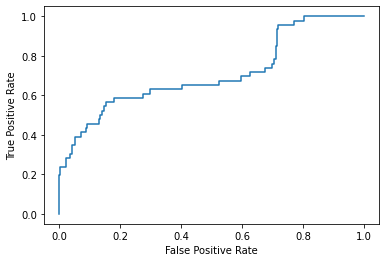

In [83]:
# Partial charges similairty roc curve of the most recent probe molecule 
fpr, tpr, _ = roc_curve(newlist['Active_NotActive'],simEsp)
plt.plot(fpr,tpr)
plt.title('ROC AUC curve for ESP similarity')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

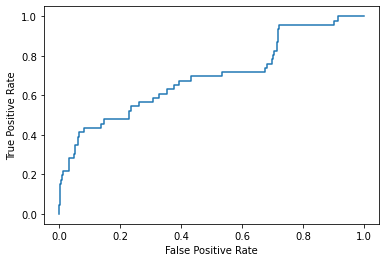

In [84]:
# Partial charges similairty roc curve of the most recent probe molecule 
fpr, tpr, _ = roc_curve(newlist['Active_NotActive'],avrlist)
plt.plot(fpr,tpr)
plt.title('ROC AUC curve for the average of shape and ESP similarity')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 